<a href="https://colab.research.google.com/github/patbaa/demo_notebooks/blob/master/cnn_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN fine tuning

We have seen that for the ImageNet dataset convolutional neural networks can work surprisingly well. The ImageNet dataset consists of more than 1 million training image. Until now we stated that the deep learning revolution could happen due to the increasing computational power and the enormous data availability.   
**What if we do not have too many images?**
 1. go and collect much more data
 2. use the knowledge learned from the ImageNet dataset
 
Using a neural network that was trained on 1 million ImageNet images must have a **good inner representation** (finding round objects, eyes, text etc.) for photos of various objects. The idea of transfer learning is that we rely on these representations. Unfortunately we **cannot use the pre-trained model as it is**, because we have different categories than the ImageNet, but as we have real-world (ImageNet-like) images we can use all the pre-trained CNN weights except for the last prediction layer.

So we have to change the last dense layer of 1000 neurons to match our problem. We can whether train all the weight in the neural network for a small time or we can freze all the weights except for the new last layer and train only that layer. It is also common that one trains only the last layer and when the weights converged they unfreze the rest of the weights to train all of them for a short time.

Sometimes the learning rate changes from layer to layer. We will see later that CNNs first layers are usually captures general properties of images (round object or parallel lines) and the last layers are more task specific (dog eye, human head etc.). In general during transfer learning we want to keep as much information one dataset to the other as possible. As the first layers are generic they do not need to change much, so a much lower learning rate can be fine. The last one are more task specific so we have to train them more (with higher learning rate).

In [0]:
%tensorflow_version 2.x

In [0]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dogs and cats

We will use data from the Kaggle challenge 'Dogs and cats'. To make things more difficult we restrict ourselves to a tiny subset of the training images, 300 images for dogs and 300 for cats.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg">

https://www.kaggle.com/c/dogs-vs-cats/

ImageNet pre-trained models seem to be a perfect choice as ImageNet contains 100+ different dog breeds, so the network weights should be exceptional when it comes to dog classification.

**You can download and unzip the data via uncommenting the two cells below and running them!**

In [3]:
# download the prepared dataset
!wget http://patbaa.web.elte.hu/dogscats.zip

--2020-04-03 17:00:39--  http://patbaa.web.elte.hu/dogscats.zip
Resolving patbaa.web.elte.hu (patbaa.web.elte.hu)... 157.181.1.225
Connecting to patbaa.web.elte.hu (patbaa.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 572022737 (546M) [application/zip]
Saving to: ‘dogscats.zip.1’

dogscats.zip.1      100%[===================>] 545.52M  5.45MB/s    in 80s     

2020-04-03 17:02:00 (6.79 MB/s) - ‘dogscats.zip.1’ saved [572022737/572022737]



In [4]:
# unzip it
!unzip -q dogscats.zip

replace test/dog/dog.10010.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yA
replace test/dog/dog.10012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
train_dogs = list(Path('train/dog/').glob('*'))
train_cats = list(Path('train/cat/').glob('*'))

print(f'#Training images: {len(train_cats), len(train_dogs)}')

test_dogs = list(Path('test/dog/').glob('*'))
test_cats = list(Path('test/cat/').glob('*'))

print(f'#Test images: {len(test_cats), len(test_dogs)}')

#Training images: (300, 300)
#Test images: (12200, 12200)


### Most of the images are proper, but a few ones are tricky
looking only at the training images, we expect similar in the test ones too!

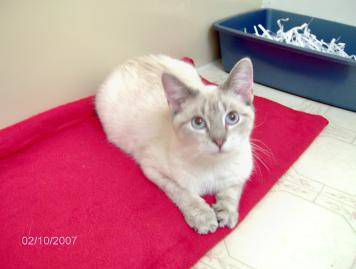

In [6]:
Image.open('train/cat/cat.11100.jpg')

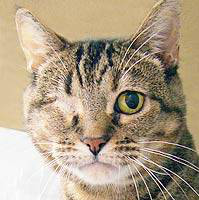

In [7]:
Image.open('train/cat/cat.11368.jpg')

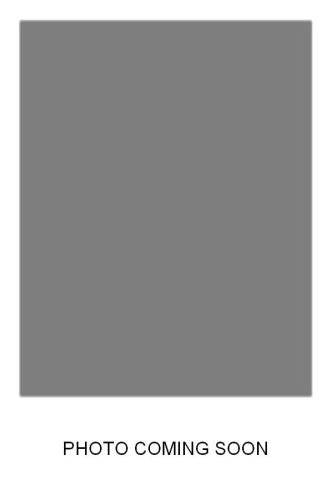

In [8]:
Image.open('train/cat/cat.11184.jpg')

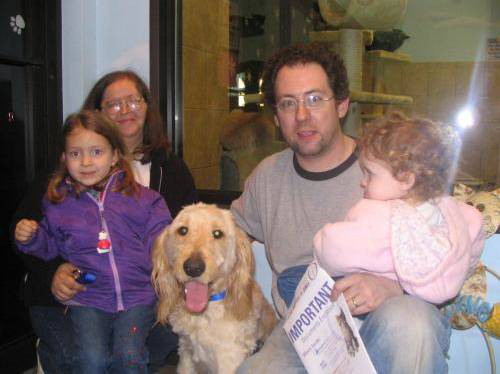

In [9]:
Image.open('train/dog/dog.11125.jpg')

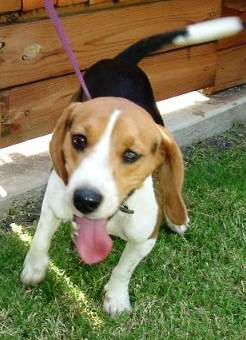

In [10]:
Image.open('train/dog/dog.11350.jpg')

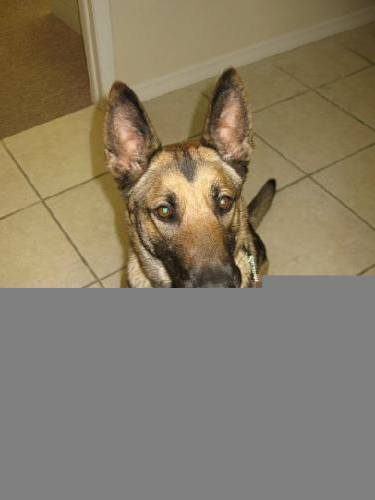

In [11]:
Image.open('train/dog/dog.11191.jpg')

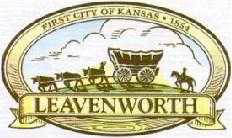

In [12]:
Image.open('train/dog/dog.11299.jpg')

## Setting up the models

We will use ResNet50 (will learn about it later). We use two models:
 1. randomly initialized
 2. pre-trained on imagenet
 
As ImageNet contains 1000 categories we have to change tha last layer to have 1 neuron instead of 1000. We will train a binary classifier (0-1) to indicate if we have a cat or a dog on the image. 
 - binary crossentropy
 - sigmoid instead of softmax
   - softmax with one neuron $\to$ constant 1 prediction always
   
We could have also used 2 neurons with categorical crossentropy and softmax.

In [0]:
# we could set classes=1, but the default activation is softmax
# softmax with one neuron is not the best idea...
model = ResNet50(weights=None)
pretrained_model = ResNet50(weights='imagenet')

Removing the last layer and creating a new model which has 1 neuron at the end with sigmoid activation.

In [0]:
model._layers.pop()
inputs = model.input
output = model.layers[-1].output
output = Dense(1, activation='sigmoid')(output)
model = Model(inputs, output)

In [0]:
pretrained_model._layers.pop()
inputs = pretrained_model.input
output = pretrained_model.layers[-1].output
output = Dense(1, activation='sigmoid')(output)
pretrained_model = Model(inputs, output)

For the pre-trained model we freeze all the layers but the last.

In [0]:
for i in pretrained_model.layers[:-1]:
    i.trainable = False

Check the models and compare the trainable parameters! Later it worth to chech the training times too!

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Dataloader

Previously we just loaded all the data to memory and feeded the neural network with it. For larger datset it often happens that it simply does not fit into the RAM. Datagenerators are functions that provide one batch of data at a time.

Tf-keras has a built-in ImageDataGenerator, we will use that here, but it does not take too much effort to write and own dataloader. Image augmentation can be done within the dataloader.

The categories are matched from the folder names.

In [0]:
def imagenet_convert(img):
    img  = img.astype(float)[...,::-1] # RGB --> BGR
    img -= [103.939, 116.779, 123.68]
    return img

In [20]:
train_datagenerator = ImageDataGenerator(preprocessing_function=imagenet_convert)
test_datagenerator  = ImageDataGenerator(preprocessing_function=imagenet_convert)

train_datagenerator = train_datagenerator.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

test_datagenerator = test_datagenerator.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

Found 600 images belonging to 2 classes.
Found 24400 images belonging to 2 classes.


Compile the models with Adam optimizer using learning rate of $10^{-4}$.

In [0]:
model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
pretrained_model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

### Fit the models for 25 epochs and run the validation efter every 5th epoch. 

The training time is pretty low for a single epoch, however validation is much slower. It happens because we have 40x images to validate on as to train on. 

In [22]:
model.fit(train_datagenerator, steps_per_epoch=len(train_datagenerator),
          validation_data=test_datagenerator, validation_steps = len(test_datagenerator),
          validation_freq=5, epochs=25)

Epoch 1/25
38/38 [==============================] - 8s 199ms/step - loss: 0.8306 - accuracy: 0.5467
Epoch 2/25
38/38 [==============================] - 7s 172ms/step - loss: 0.6439 - accuracy: 0.6283
Epoch 3/25
38/38 [==============================] - 7s 173ms/step - loss: 0.6184 - accuracy: 0.6667
Epoch 4/25
38/38 [==============================] - 7s 174ms/step - loss: 0.6422 - accuracy: 0.6650
Epoch 5/25
38/38 [==============================] - 134s 4s/step - loss: 0.6272 - accuracy: 0.6883 - val_loss: 0.8169 - val_accuracy: 0.5034
Epoch 6/25
38/38 [==============================] - 7s 180ms/step - loss: 0.6137 - accuracy: 0.6717
Epoch 7/25
38/38 [==============================] - 7s 179ms/step - loss: 0.6130 - accuracy: 0.6933
Epoch 8/25
38/38 [==============================] - 7s 180ms/step - loss: 0.5257 - accuracy: 0.7533
Epoch 9/25
38/38 [==============================] - 7s 180ms/step - loss: 0.5516 - accuracy: 0.7517
Epoch 10/25
38/38 [==============================] - 134s 4

In [23]:
pretrained_model.fit(train_datagenerator, steps_per_epoch=len(train_datagenerator),
                     validation_data=test_datagenerator, validation_steps = len(test_datagenerator),
                     validation_freq=5, epochs=25)

Epoch 1/25
38/38 [==============================] - 3s 83ms/step - loss: 0.4560 - accuracy: 0.8033
Epoch 2/25
38/38 [==============================] - 3s 84ms/step - loss: 0.3290 - accuracy: 0.9017
Epoch 3/25
38/38 [==============================] - 3s 83ms/step - loss: 0.2510 - accuracy: 0.9350
Epoch 4/25
38/38 [==============================] - 3s 84ms/step - loss: 0.2069 - accuracy: 0.9517
Epoch 5/25
38/38 [==============================] - 133s 3s/step - loss: 0.1711 - accuracy: 0.9600 - val_loss: 0.1793 - val_accuracy: 0.9568
Epoch 6/25
38/38 [==============================] - 3s 85ms/step - loss: 0.1451 - accuracy: 0.9683
Epoch 7/25
38/38 [==============================] - 3s 87ms/step - loss: 0.1351 - accuracy: 0.9717
Epoch 8/25
38/38 [==============================] - 3s 87ms/step - loss: 0.1127 - accuracy: 0.9783
Epoch 9/25
38/38 [==============================] - 3s 86ms/step - loss: 0.1062 - accuracy: 0.9767
Epoch 10/25
38/38 [==============================] - 134s 4s/step -

# Summary

Both network became better by time, but the randomly initialized network could achieve only <70% (with some ideas we could surely get much better) accuracy while the pre-trained model achieved >97% accuracy.   
Also, the training time was ~50% lower for the pre-trained model for each epoch.

https://www.kaggle.com/c/dogs-vs-cats/leaderboard   
6 years ago the winner achieved 98.9%, 10th place 97.9%, 30th place was 96.7% (but on a different test set)

**We achieved those results with training for ~3 minutes (not counting the validation time).**


### Further improvements
 - clean dataset, remove mislabeled images
 - augmentation
 - test time augmentation
 - careful learning rate schedule
 - fine-tuning other pre-trained models from the [model zoo](https://www.tensorflow.org/api_docs/python/tf/keras/applications/) and averaging them (ensemble)